In [28]:
import pandas as pd
from xgboost import XGBClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate

In [29]:
df = pd.read_csv('SBAnational.csv', low_memory=False)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      899164 non-null  int64  
 1   Name               899150 non-null  object 
 2   City               899134 non-null  object 
 3   State              899150 non-null  object 
 4   Zip                899164 non-null  int64  
 5   Bank               897605 non-null  object 
 6   BankState          897598 non-null  object 
 7   NAICS              899164 non-null  int64  
 8   ApprovalDate       899164 non-null  object 
 9   ApprovalFY         899164 non-null  object 
 10  Term               899164 non-null  int64  
 11  NoEmp              899164 non-null  int64  
 12  NewExist           899028 non-null  float64
 13  CreateJob          899164 non-null  int64  
 14  RetainedJob        899164 non-null  int64  
 15  FranchiseCode      899164 non-null  int64  
 16  Ur

In [31]:
df['MIS_Status'].value_counts()

P I F     739609
CHGOFF    157558
Name: MIS_Status, dtype: int64

In [32]:
X = df.copy()
X = X.drop(columns=['Name', 'LoanNr_ChkDgt', 'Bank', 
                     'BankState', 'DisbursementDate', 'ApprovalDate', 
                    'ApprovalFY', 'FranchiseCode', 'Zip', 'City', 'ChgOffDate', 'SBA_Appv', 'BalanceGross', 'DisbursementGross', 'ChgOffPrinGr'])

In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   State        899150 non-null  object 
 1   NAICS        899164 non-null  int64  
 2   Term         899164 non-null  int64  
 3   NoEmp        899164 non-null  int64  
 4   NewExist     899028 non-null  float64
 5   CreateJob    899164 non-null  int64  
 6   RetainedJob  899164 non-null  int64  
 7   UrbanRural   899164 non-null  int64  
 8   RevLineCr    894636 non-null  object 
 9   LowDoc       896582 non-null  object 
 10  MIS_Status   897167 non-null  object 
 11  GrAppv       899164 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 82.3+ MB


In [34]:
X = X.dropna(subset=['MIS_Status'])

In [35]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 897167 entries, 0 to 899163
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   State        897154 non-null  object 
 1   NAICS        897167 non-null  int64  
 2   Term         897167 non-null  int64  
 3   NoEmp        897167 non-null  int64  
 4   NewExist     897033 non-null  float64
 5   CreateJob    897167 non-null  int64  
 6   RetainedJob  897167 non-null  int64  
 7   UrbanRural   897167 non-null  int64  
 8   RevLineCr    892647 non-null  object 
 9   LowDoc       894589 non-null  object 
 10  MIS_Status   897167 non-null  object 
 11  GrAppv       897167 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 89.0+ MB


In [36]:
X['GrAppv'] = X['GrAppv'].str.replace('$', '').str.replace(',','').str.strip().astype('float64').astype('int64')

/tmp/ipykernel_78568/3200432588.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X['GrAppv'] = X['GrAppv'].str.replace('$', '').str.replace(',','').str.strip().astype('float64').astype('int64')


In [37]:
values = ['0','T','1','R','`','2','C','3',',','7','A','5','.','4','-','Q']
X['RevLineCr'] = X['RevLineCr'].mask(X.RevLineCr.isin(values))

In [38]:
values = ['0','C','S','A','R','1']
X['LowDoc'] = X['LowDoc'].mask(X.LowDoc.isin(values))

In [39]:
X['LowDoc'].value_counts()

N    780997
Y    110171
Name: LowDoc, dtype: int64

In [40]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 897167 entries, 0 to 899163
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   State        897154 non-null  object 
 1   NAICS        897167 non-null  int64  
 2   Term         897167 non-null  int64  
 3   NoEmp        897167 non-null  int64  
 4   NewExist     897033 non-null  float64
 5   CreateJob    897167 non-null  int64  
 6   RetainedJob  897167 non-null  int64  
 7   UrbanRural   897167 non-null  int64  
 8   RevLineCr    619912 non-null  object 
 9   LowDoc       891168 non-null  object 
 10  MIS_Status   897167 non-null  object 
 11  GrAppv       897167 non-null  int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 89.0+ MB


In [41]:
X['NewExist'] = X['NewExist'].replace({2:False, 1:True})

In [42]:
cat = ['RevLineCr', 'LowDoc', 'NewExist', 'NAICS', 'State']

In [43]:
X['NAICS'] = X['NAICS'].astype('str').apply(lambda x : x[:2])

In [44]:
y = X['MIS_Status'].replace({'P I F':0, 'CHGOFF':1}) 
X = X.drop(['MIS_Status'], axis=1)

num = list(X.select_dtypes(include=['int', 'float']).columns)

In [45]:
ohe = OneHotEncoder()
preprocessor = make_column_transformer(
    (ohe, cat)
)

In [46]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 897167 entries, 0 to 899163
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   State        897154 non-null  object
 1   NAICS        897167 non-null  object
 2   Term         897167 non-null  int64 
 3   NoEmp        897167 non-null  int64 
 4   NewExist     897033 non-null  object
 5   CreateJob    897167 non-null  int64 
 6   RetainedJob  897167 non-null  int64 
 7   UrbanRural   897167 non-null  int64 
 8   RevLineCr    619912 non-null  object
 9   LowDoc       891168 non-null  object
 10  GrAppv       897167 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 82.1+ MB


In [47]:
for col in cat:
  print(X[col].value_counts())

N    419252
Y    200660
Name: RevLineCr, dtype: int64
N    780997
Y    110171
Name: LowDoc, dtype: int64
True     643446
False    253587
Name: NewExist, dtype: int64
0     201667
44     84567
81     72395
54     67922
72     67511
23     66492
62     55264
42     48673
45     42408
33     38206
56     32529
48     20198
32     17905
71     14616
53     13588
31     11792
51     11362
52      9470
11      8995
61      6401
49      2210
21      1851
22       662
55       256
92       227
Name: NAICS, dtype: int64
CA    130488
TX     70401
NY     57394
FL     41192
PA     34801
OH     32498
IL     29594
MA     25092
MN     24359
NJ     24010
WA     23255
GA     22272
WI     21021
MO     20652
CO     20598
MI     20493
UT     18772
AZ     17624
NC     14286
IN     14079
MD     13259
VA     13207
CT     12127
NH     12023
IA     11986
KS     11455
OR     11041
OK      9945
LA      9570
ID      9496
TN      9400
RI      8948
MT      8737
AL      8360
NV      8022
KY      7720
MS      7668
NE

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.05, random_state=42, stratify=y)

In [49]:
X_train

,State,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,GrAppv
877120,FL,44,2,2,True,1,2,1,Y,N,70000
113801,IL,0,180,110,True,0,0,0,N,N,500000
399187,WI,0,120,1,False,0,0,1,N,N,62000
302622,IL,48,60,2,False,1,1,1,N,N,15000
266298,MD,44,240,12,True,0,0,0,NaN,N,625000
...,...,...,...,...,...,...,...,...,...,...,...
704157,MA,44,96,5,True,0,5,1,NaN,N,190000
801213,OH,0,120,5,True,0,0,0,N,Y,75000
475246,SD,45,180,3,True,0,0,0,N,N,95000
285255,VT,0,240,6,True,6,0,0,NaN,N,136000


In [87]:
base_xgb = XGBClassifier(objective='binary:logistic',
 seed=42, random_state=42, tree_method='gpu_hist', n_jobs=-1, early_stopping_rounds=10
eval_set=[(X_test, y_test)])

base_xgb_pipe = make_pipeline(preprocessor, base_xgb)

base_xgb_pipe.fit(X_train, 
                  y_train,
                  xgbclassifier__verbose=False
                #   xgbclassifier__early_stopping_rounds=10
                  )

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2884517162.py, line 1)

In [51]:
y_pred = cross_val_predict(base_xgb_pipe, X_train, y_train)

In [52]:
print(classification_report(y_train, y_pred, target_names = ['faible', 'élevée']))

              precision    recall  f1-score   support

      faible       0.82      1.00      0.90    702628
      élevée       0.51      0.00      0.01    149680

    accuracy                           0.82    852308
   macro avg       0.67      0.50      0.46    852308
weighted avg       0.77      0.82      0.75    852308



In [53]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred))

In [54]:
positives = sum(y) / len(y)
negatives = 1 - positives
scale_ratio = negatives / positives

In [55]:
scale_ratio

4.694201500399852

In [75]:
param_grid = {'xgbclassifier__max_depth' : [7,12,15],
              'xgbclassifier__learning_rate' : [0.5],
              'xgbclassifier__gamma' : [1],
              'xgbclassifier__reg_lambda' : [15],
              'xgbclassifier__scale_pos_weight' : [scale_ratio]
              }

grid = GridSearchCV(
    estimator=base_xgb_pipe,
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1,
    cv=3
)

grid.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=7, xgbclassifier__reg_lambda=15, xgbclassifier__scale_pos_weight=4.694201500399852; total time=   1.9s
[CV] END xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=7, xgbclassifier__reg_lambda=15, xgbclassifier__scale_pos_weight=4.694201500399852; total time=   2.0s
[CV] END xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=7, xgbclassifier__reg_lambda=15, xgbclassifier__scale_pos_weight=4.694201500399852; total time=   2.0s
[CV] END xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=12, xgbclassifier__reg_lambda=15, xgbclassifier__scale_pos_weight=4.694201500399852; total time=   2.1s
[CV] END xgbclassifier__gamma=1, xgbclassifier__learning_rate=0.5, xgbclassifier__max_depth=12, xgbclassifier__reg_lambda=15, xgbclassifier__scale_pos_weight=4.

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['RevLineCr',
                                                                          'LowDoc',
                                                                          'NewExist',
                                                                          'NAICS',
                                                                          'State'])])),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=No...
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__gamma': [1],
                         'xgbclassifier__learning_rate': [0.5],
                         'xgbclassifier__max_depth': [7, 12, 15],
                         'xgbclassifier__reg_lambda': [15],
                         'xgbclassifier__scale_pos_weight': [4.694201500399852]},
             scoring='roc_auc', verbose=2)

In [81]:
grid.score(X_test,y_test)

0.6868829738556659

In [76]:
xgb_pipe = grid.best_estimator_

In [77]:
grid.best_params_

{'xgbclassifier__gamma': 1,
 'xgbclassifier__learning_rate': 0.5,
 'xgbclassifier__max_depth': 7,
 'xgbclassifier__reg_lambda': 15,
 'xgbclassifier__scale_pos_weight': 4.694201500399852}

In [78]:
y_pred = cross_val_predict(xgb_pipe, X_train, y_train)

In [79]:
print(classification_report(y_train, y_pred, target_names = ['faible', 'élevée']))

              precision    recall  f1-score   support

      faible       0.90      0.60      0.72    702628
      élevée       0.27      0.68      0.38    149680

    accuracy                           0.61    852308
   macro avg       0.58      0.64      0.55    852308
weighted avg       0.79      0.61      0.66    852308



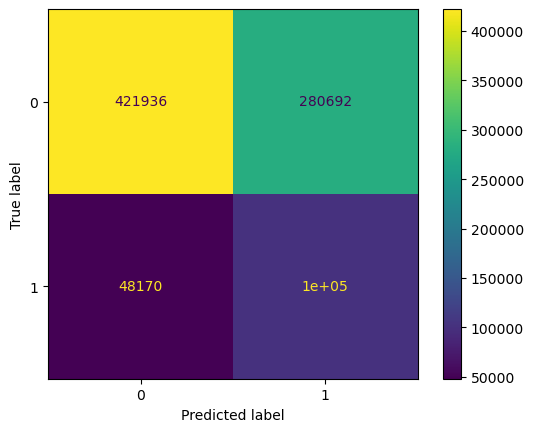

In [80]:
ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred)).plot()

In [72]:
import pickle
pickle.dump(xgb_pipe, open('rfc.pkl', 'wb'))